<a href="https://colab.research.google.com/github/dogukartal/IBM_AI_Labs/blob/main/Gen%20AI%20Foundational%20Models%20for%20NLP%20%26%20Language%20Understanding/Classifying_Documents_AG_NEWS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Documents
---

# Setup


In [ ]:
!pip install -qy pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==0.20.1
!pip install pmdarima -U
!pip install --upgrade pmdarima==2.0.2
!pip install -Uqq plotly
!pip install -qq dash

In [ ]:
!pip uninstall -y torch torchtext torchdata
!pip install -qq torch==2.0.0
!pip install -qq torchtext==0.15.1
!pip install -qq torchdata==0.6.0

In [5]:
!pip install -Uqq portalocker>=2.0.0

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import numpy as np
from torchtext.datasets import AG_NEWS
from IPython.display import Markdown as md
from tqdm import tqdm

from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import AG_NEWS
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from sklearn.manifold import TSNE
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split

from torchtext.data.utils import get_tokenizer

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [2]:
# Helper function
def plot(COST,ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

---


## Text classification

In [35]:
train_iter= iter(AG_NEWS(split="train"))

ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}

y,text= next((train_iter))
print(ag_news_label[y], text)

Business Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


In [36]:
# Number of Classes
num_class = len(set([label for (label, text) in train_iter ]))
num_class

4

In [37]:
# Reinitialize train_iter
train_iter = AG_NEWS(split="train")

# Define tokenizer and yield_tokens
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text.lower())  # Lowercase conversion for consistency

# Build vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Print the vocabulary size and sample tokens
print(f"Vocabulary size: {len(vocab)}")
print(f"Sample tokens: {list(vocab.get_stoi().keys())[:10]}")

Vocabulary size: 95811
Sample tokens: ['zzz', 'zygmunt', 'zwiki', 'zvidauri', 'zurine', 'zurab', 'zuo', 'zuloaga', 'zovko', 'zotinca']


In [6]:
vocab(["well","home"])

[582, 160]

### Dataset


In [38]:
# Split the dataset into training and testing iterators.
train_iter, test_iter = AG_NEWS()

# Convert the training and testing iterable datasets to map-style datasets
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Data loader


In [40]:
def text_pipeline(x):
  return vocab(tokenizer(x))

def label_pipeline(x):
   return int(x) - 1

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text) # Processed text
        offsets.append(processed_text.size(0)) # Arranging offset list
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

In [41]:
BATCH_SIZE = 64

# Convert the dataset objects to a data loader by applying the collate function
train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [42]:
# Example Iteration
label, text, offsets=next(iter(valid_dataloader ))
label, text, offsets

(tensor([3, 0, 1, 3, 2, 1, 0, 1, 0, 1, 1, 1, 1, 0, 2, 2, 2, 2, 0, 3, 3, 3, 0, 0,
         0, 0, 0, 0, 0, 3, 3, 1, 3, 3, 1, 0, 3, 1, 1, 1, 0, 1, 1, 2, 0, 0, 1, 1,
         3, 2, 2, 2, 3, 1, 3, 3, 2, 2, 1, 2, 0, 2, 0, 2], device='cuda:0'),
 tensor([2951, 1464, 9568,  ...,  163,   41, 1532], device='cuda:0'),
 tensor([   0,   54,   85,  144,  185,  230,  295,  333,  365,  415,  470,  514,
          551,  589,  632,  679,  722,  759,  805,  848,  892,  921,  954,  984,
         1029, 1075, 1110, 1166, 1191, 1219, 1262, 1275, 1328, 1365, 1395, 1425,
         1470, 1513, 1556, 1595, 1639, 1700, 1736, 1774, 1817, 1865, 1918, 1959,
         2000, 2038, 2121, 2144, 2173, 2212, 2256, 2291, 2313, 2354, 2401, 2449,
         2487, 2540, 2572, 2610], device='cuda:0'))

In [43]:
text.shape

torch.Size([2662])

### Neural network


In [44]:
from torch import nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [45]:
emsize = 64
vocab_size = len(vocab)
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)
model

TextClassificationModel(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

In [46]:
# Verifying the output shape of the model
predicted_label=model(text, offsets)
predicted_label.shape

torch.Size([64, 4])

In [47]:
# Prediction Function
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text)).to(device)
        output = model(text, torch.tensor([0]).to(device))
        return ag_news_label[output.argmax(1).item() + 1]

predict("I like sports", text_pipeline )

'Sci/Tec'

In [48]:
def evaluate(dataloader):
    model.eval() # Evaluation Mode
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

evaluate(test_dataloader)

0.2643421052631579

## Train the model


In [49]:
LR=0.1

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [50]:
EPOCHS = 20
cum_loss_list=[]
acc_epoch=[]
acc_old=0

for epoch in tqdm(range(1, EPOCHS + 1)):
    model.train() # Training Mode
    cum_loss=0
    for idx, (label, text, offsets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1) # Gradient Clipping
        optimizer.step()
        cum_loss+=loss.item()

    cum_loss_list.append(cum_loss)
    accu_val = evaluate(valid_dataloader)
    acc_epoch.append(accu_val)

    if accu_val > acc_old:
      acc_old= accu_val
      torch.save(model.state_dict(), 'my_model.pth')

100%|██████████| 20/20 [03:15<00:00,  9.76s/it]


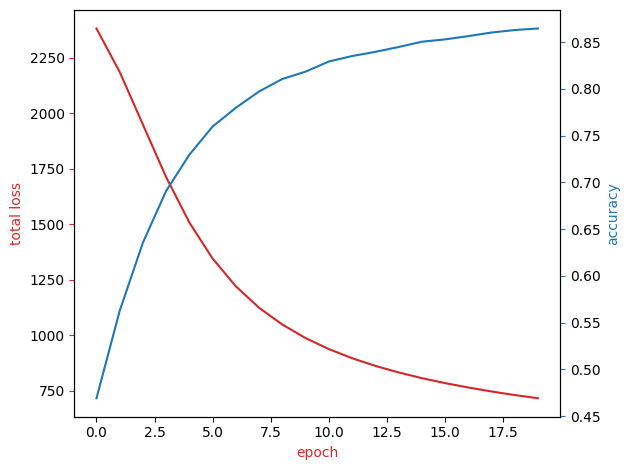

In [51]:
plot(cum_loss_list,acc_epoch)

In [52]:
evaluate(test_dataloader)

0.8609210526315789

In [53]:
# Get the first batch from the validation data
batch = next(iter(valid_dataloader))

# Extract the text and offsets from the batch
label, text, offsets = batch

# Send the data to the device (GPU if available)
text = text.to(device)
offsets = offsets.to(device)

# Get the embeddings bag output for the batch
embedded = model.embedding(text, offsets)

# Convert the embeddings tensor to a numpy array
embeddings_numpy = embedded.detach().cpu().numpy()

# Perform t-SNE on the embeddings to reduce their dimensionality to 3D.
X_embedded_3d = TSNE(n_components=3).fit_transform(embeddings_numpy)

# Create a 3D scatter plot using Plotly
trace = go.Scatter3d(
    x=X_embedded_3d[:, 0],
    y=X_embedded_3d[:, 1],
    z=X_embedded_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=label.cpu().numpy(),  # Use label information for color
        colorscale='Viridis',  # Choose a colorscale
        opacity=0.8
    )
)

layout = go.Layout(title="3D t-SNE Visualization of Embeddings",
                   scene=dict(xaxis_title='Dimension 1',
                              yaxis_title='Dimension 2',
                              zaxis_title='Dimension 3'))

fig = go.Figure(data=[trace], layout=layout)
fig.show()

In [54]:
article="""Canada navigated a stiff test against the Republic of Ireland on a rain soaked evening in Perth, coming from behind to claim a vital 2-1 victory at the Women’s World Cup.
Katie McCabe opened the scoring with an incredible Olimpico goal – scoring straight from a corner kick – as her corner flew straight over the despairing Canada goalkeeper Kailen Sheridan at Perth Rectangular Stadium in Australia.
Just when Ireland thought it had safely navigated itself to half time with a lead, Megan Connolly failed to get a clean connection on a clearance with the resulting contact squirming into her own net to level the score.
Minutes into the second half, Adriana Leon completed the turnaround for the Olympic champion, slotting home from the edge of the area to seal the three points."""

In [55]:
result = predict(article, text_pipeline)

markdown_content = f'''
<div style="background-color: lightgray; padding: 10px;">
    <h3>{article}</h3>
    <h4>The category of the news article: {result}</h4>
</div>
'''

md(markdown_content)


<div style="background-color: lightgray; padding: 10px;">
    <h3>Canada navigated a stiff test against the Republic of Ireland on a rain soaked evening in Perth, coming from behind to claim a vital 2-1 victory at the Women’s World Cup.
Katie McCabe opened the scoring with an incredible Olimpico goal – scoring straight from a corner kick – as her corner flew straight over the despairing Canada goalkeeper Kailen Sheridan at Perth Rectangular Stadium in Australia.
Just when Ireland thought it had safely navigated itself to half time with a lead, Megan Connolly failed to get a clean connection on a clearance with the resulting contact squirming into her own net to level the score.
Minutes into the second half, Adriana Leon completed the turnaround for the Olympic champion, slotting home from the edge of the area to seal the three points.</h3>
    <h4>The category of the news article: Sports</h4>
</div>


In [56]:
new_articles = [
    "International talks have made significant headway with the signing of a climate accord that commits countries to reduce emissions by 40% over the next two decades. World leaders expressed optimism at the conclusion of the summit.",
    "In a stunning upset, the underdog team won the national title, beating the favorites in a match that featured an incredible comeback and a last-minute goal that sealed their victory in front of a record crowd.",
    "Market analysts are optimistic as the tech startup's stock prices soared after the announcement of their latest product, which promises to revolutionize how we interact with smart devices.",
    "A recent study published in a leading scientific journal suggests that a new drug has shown promise in the treatment of Alzheimer's disease, outperforming current leading medications in early clinical trials.",
    "Diplomatic relations have taken a positive turn with the recent peace talks that aim to end decades of conflict. The ceasefire agreement has been welcomed by the international community.",
    "Economic indicators show a sharp rebound in manufacturing, with the automobile industry leading the charge. Analysts predict this surge will result in significant job creation over the next year.",
    "Researchers at the university's astrophysics department have discovered a potentially habitable exoplanet. The planet, which lies in a nearby star system, has conditions that could support liquid water and, possibly, life.",
    "The sports world is in shock as a legendary player announces their retirement. Over an illustrious 20-year career, the athlete has amassed numerous records and is regarded as one of the greatest to ever play the game.",
    "A multinational corporation has announced a major investment in renewable energy. The initiative includes the construction of new wind farms and solar panels that will power hundreds of thousands of homes.",
    "Climate scientists warn that the melting of the polar ice caps has been accelerating at an alarming rate, raising sea levels and threatening coastal cities worldwide with increased flooding risks."
]

In [57]:
model.load_state_dict(torch.load('my_model.pth'))
model.eval()

for i, article in enumerate(new_articles, start=1):
    prediction = predict(article, text_pipeline)
    print(f"Article {i} is classified as: {prediction}\n")

Article 1 is classified as: World

Article 2 is classified as: Sports

Article 3 is classified as: Sci/Tec

Article 4 is classified as: Sci/Tec

Article 5 is classified as: World

Article 6 is classified as: Business

Article 7 is classified as: Sci/Tec

Article 8 is classified as: Sports

Article 9 is classified as: Sci/Tec

Article 10 is classified as: Sci/Tec

